In [56]:
import os, time, sys, pathlib, json, glob
import math, random
import datetime
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import sklearn.metrics

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
from IPython.display import display,Image,Markdown,HTML

In [57]:
import os
from collections import defaultdict

# Dossier de destination contenant les images copiées
destination_dir = './selected_data_2/images/'

# Initialiser un compteur pour chaque race
image_counts = defaultdict(int)

# Vérifier si le dossier de destination existe
if os.path.exists(destination_dir):
    # Parcourir les dossiers de races
    for breed_dir in os.listdir(destination_dir):
        breed_path = os.path.join(destination_dir, breed_dir)
        # Vérifier si c'est bien un dossier
        if os.path.isdir(breed_path):
            # Compter les fichiers images dans le dossier
            image_counts[breed_dir] = len([img for img in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, img))])
    
    # Afficher les résultats
    for breed, count in image_counts.items():
        print(f"{breed}: {count} images")
else:
    print(f"Le dossier {destination_dir} n'existe pas. Veuillez vérifier le chemin.")

rottweiler: 152 images
labrador: 171 images
cocker: 159 images
chihuahua: 152 images
doberman: 150 images
chow: 196 images
staff: 164 images
malinois: 150 images
boxer: 151 images
bulldog: 159 images


In [58]:
data_dir = pathlib.Path('./selected_data_2/images')
print(os.path.abspath(data_dir))

/Users/anthonydavid/Workspace/Openclassrooms/projet_6/selected_data_2/images


In [59]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1604


Train-Val-Test splitting

In [60]:
img_height = 224
img_width = 224

# Proportions pour la division des données
test_split = 0.1  # 10% pour le test
validation_split = 0.2  # 20% pour la validation

# Taille du batch (garde la valeur d'origine)
batch_size = image_count

# Étape 1 : Créer le dataset de base pour une division initiale train-test (90% train + val, 10% test)
train_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=test_split,  # 10% pour le test
    subset="training",  # 90% des images pour train + validation
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=test_split,  # 10% pour le test
    subset="validation",  # 10% des images pour le test
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Étape 2 : Diviser train_val_data en train (70%) et validation (20%)
# Calculer la proportion correcte de validation sur le dataset de train+val
train_val_split = validation_split / (1 - test_split)  # ~22.2% pour validation du 90%

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset="training",  # 77.8% des images pour l'entraînement
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset="validation",  # 22.2% des images pour la validation
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Récupérer les noms des classes
class_names = train_data.class_names
print("Class names:", class_names)
num_classes = len(class_names)
print("Number of classes:", num_classes)

Found 1604 files belonging to 10 classes.
Using 1444 files for training.
Found 1604 files belonging to 10 classes.
Using 160 files for validation.
Found 1604 files belonging to 10 classes.
Using 1248 files for training.
Found 1604 files belonging to 10 classes.
Using 356 files for validation.
Class names: ['boxer', 'bulldog', 'chihuahua', 'chow', 'cocker', 'doberman', 'labrador', 'malinois', 'rottweiler', 'staff']
Number of classes: 10


In [61]:
# Extraction de x_train, y_train, x_val, y_val, x_test, y_test

def extract_images_and_labels(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy().astype("uint8"))
        labels.append(label_batch)
    images = tf.concat(images, axis=0).numpy()
    labels = tf.concat(labels, axis=0).numpy()
    return images, labels

x_train, y_train = extract_images_and_labels(train_data)
x_val, y_val = extract_images_and_labels(val_data)
x_test, y_test = extract_images_and_labels(test_data)

# Calcul du nombre total d'images
total_images = x_train.shape[0] + x_val.shape[0] + x_test.shape[0]

# Afficher les tailles et pourcentages des ensembles
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}, ({(x_train.shape[0] / total_images) * 100:.2f}%)")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}, ({(x_val.shape[0] / total_images) * 100:.2f}%)")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}, ({(x_test.shape[0] / total_images) * 100:.2f}%)")

x_train: (1248, 224, 224, 3), y_train: (1248,), (70.75%)
x_val: (356, 224, 224, 3), y_val: (356,), (20.18%)
x_test: (160, 224, 224, 3), y_test: (160,), (9.07%)


2024-10-25 06:03:04.719468: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 1.3 - Visualizing some resized images

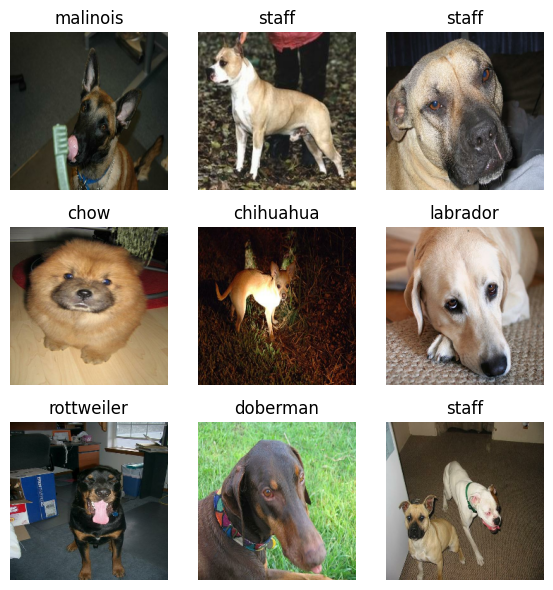

In [62]:
# Create a figure and axis for the grid of images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5)

y_train_strings = [class_names[label] for label in y_train]

# Generate and plot the images in a loop
for i in range(9):
    # Generate a random image
    random_label = random.choice(range(len(x_train)))
    image = x_train[random_label]
    name = y_train_strings[random_label]
    
    # Get the current axis and plot the image
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(name)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

## 1.4 - Create different type of images and visualize the resulting data

Here we use the following type of images : 

- RGB : Image en couleur sans modifications.
- RGB-HE : Image en couleur avec amélioration du contraste.
- L : Image en niveaux de gris.
- L-HE : Image en niveaux de gris avec amélioration du contraste.
- L-LHE : Image en niveaux de gris avec amélioration locale du contraste.
- L-CLAHE : Image en niveaux de gris avec amélioration adaptative et limitée du contraste.
- BW : Image en noir et blanc (binaire).

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

In [63]:
def images_enhancement(images, width=img_width, height=img_height, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float64
    args:
        images :         images list
        width,height :   new images size
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE | BW
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1, 'BW':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))


        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)

        if mode=='BW':
            gray_image = color.rgb2gray(img)
            threshold_value = 0.5  # Adjust this threshold value as needed
            img = np.where(gray_image < threshold_value, 1, 0)

        # ---- Add image in list of list
        out.append(img)

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

### 1.4.1 - Get an idea of the different recipes

dataset : RGB  shape=(16, 224, 224, 3)


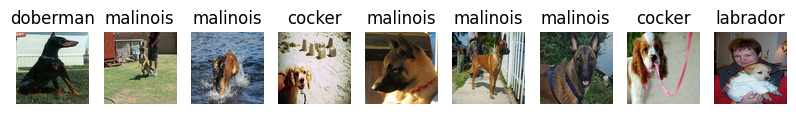

dataset : RGB-HE  shape=(16, 224, 224, 3)


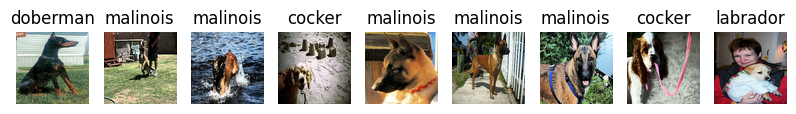

dataset : L  shape=(16, 224, 224, 1)


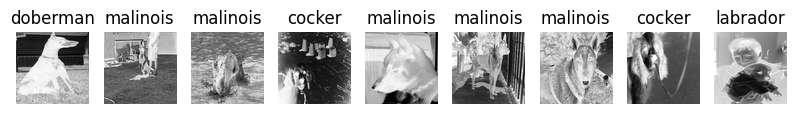

dataset : L-HE  shape=(16, 224, 224, 1)


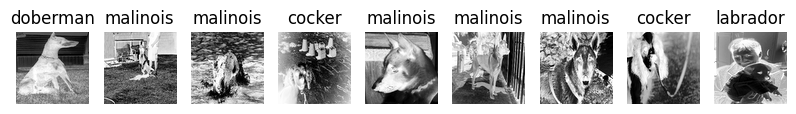

dataset : L-LHE  shape=(16, 224, 224, 1)


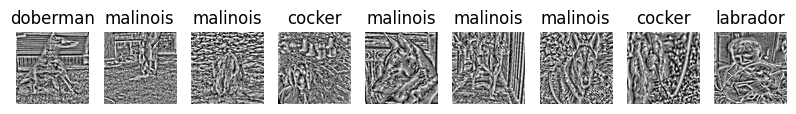

dataset : L-CLAHE  shape=(16, 224, 224, 1)


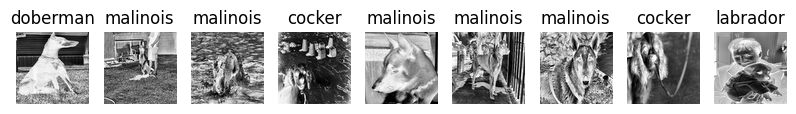

dataset : BW  shape=(16, 224, 224, 1)


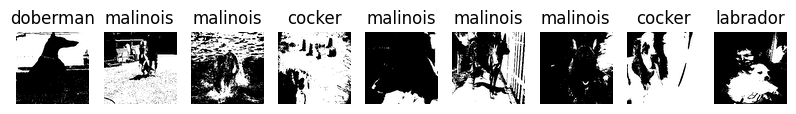

In [64]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]
y_samples_strings = [class_names[label] for label in y_samples]

datasets  = {}

datasets['RGB']      = images_enhancement(x_samples, mode='RGB')
datasets['RGB-HE']   = images_enhancement(x_samples, mode='RGB-HE')
datasets['L']        = images_enhancement(x_samples, mode='L')
datasets['L-HE']     = images_enhancement(x_samples, mode='L-HE')
datasets['L-LHE']    = images_enhancement(x_samples, mode='L-LHE')
datasets['L-CLAHE']  = images_enhancement(x_samples, mode='L-CLAHE')
datasets['BW']       = images_enhancement(x_samples, mode='BW')


# Generate and plot the images in a loop
for k, d in datasets.items():
    # Create a figure and axis for the grid of images
    fig, axes = plt.subplots(1, 9, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.5)

    print("dataset : {}  shape={}".format(k, d.shape))

    for i in range(9):
        image = d[i]
        name = y_samples_strings[i]
        
        # Get the current axis and plot the image
        ax = axes[i % 9]
        ax.imshow(image, cmap='binary', interpolation='lanczos')
        ax.set_title(name)
        ax.axis('off')
        
    # Display the grid of images
    plt.tight_layout()
    plt.show()

In [65]:
# Fonction pour sauvegarder les ensembles de données
def save_h5_dataset(x_train, y_train, x_val, y_val, x_test, y_test, filename):
    # ---- Créer le fichier h5
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_val", data=x_val)
        f.create_dataset("y_val", data=y_val)
        f.create_dataset("x_test", data=x_test)
        f.create_dataset("y_test", data=y_test)
        
    # ---- Affichage de la taille du fichier
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

In [66]:
output_dir = './data_2'

In [67]:
n_train = int(len(x_train))
n_val = int(len(x_val))
n_test = int(len(x_test))

# Afficher les paramètres
display(Markdown(f"<br>**{'Parameters'}**"))
print(f'x_train length is : {n_train}')
print(f'x_val length is   : {n_val}')
print(f'x_test length is  : {n_test}')
print(f'output dir is     : {output_dir}\n')

display(Markdown(f"<br>**{'Running...'}**"))

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_dir, mode=0o750, exist_ok=True)

# Sauvegarder chaque type de transformation
for m in ['RGB']:
    # ---- Nom de fichier pour chaque type de transformation
    filename = f'{output_dir}/set-{m}.h5'
    display(Markdown(f"<br>**{filename}**"))
    
    # ---- Amélioration des images pour chaque ensemble (train, val, test)
    x_train_new = images_enhancement(x_train, mode=m)
    x_val_new = images_enhancement(x_val, mode=m)
    x_test_new  = images_enhancement(x_test, mode=m)
        
    # ---- Sauvegarder le dataset transformé
    save_h5_dataset(x_train_new, y_train, x_val_new, y_val, x_test_new, y_test, filename)

display(Markdown(f"<br>**{'Done'}**"))

# Libérer la mémoire
x_train_new, x_val_new, x_test_new = 0, 0, 0

<br>**Parameters**

x_train length is : 1248
x_val length is   : 356
x_test length is  : 160
output dir is     : ./data_2



<br>**Running...**

<br>**./data_2/set-RGB.h5**

Dataset : ./data_2/set-RGB.h5       shape : (1248, 224, 224, 3)    size : 2025.9 Mo   (saved)


<br>**Done**

In [68]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Créer les dossiers pour les sauvegardes
run_dir = './run_transfer_mobilnetv2_v2'
figs_dir = './figs_transfer_mobilnetv2_v2'

os.makedirs(run_dir + '/models', mode=0o750, exist_ok=True)
os.makedirs(run_dir + '/logs', mode=0o750, exist_ok=True)
os.makedirs(figs_dir, mode=0o750, exist_ok=True)

# Fonction pour obtenir l'horodatage actuel
def tag_now():
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

# Callbacks : TensorBoard et sauvegarde du meilleur modèle
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

save_dir_best_model = run_dir + "/models/best_model.keras"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_dir_best_model,  # Chemin pour enregistrer le modèle
    monitor='val_accuracy',        # Surveiller la métrique de validation
    save_best_only=True,           # Sauvegarder uniquement le meilleur modèle
    mode='max',                    # Sauvegarder lorsqu'on atteint un max sur la métrique surveillée
    verbose=1                      # Afficher un message lorsqu'un modèle est sauvegardé
)

# # Callback pour sauvegarder le modèle à chaque époque
# save_dir_model_per_epoch = run_dir + "/models/model-{epoch:04d}.keras"
# savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir_model_per_epoch, verbose=0)

In [69]:
# Définir les chemins
data_path = './data_2/set-RGB.h5'

# Chargement du dataset HDF5
def read_h5_dataset(data_path):
    with h5py.File(data_path, 'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_val = f['x_val'][:]
        y_val = f['y_val'][:]
        x_test = f['x_test'][:]
        y_test = f['y_test'][:]
    return x_train, y_train, x_val, y_val, x_test, y_test

# Charger les datasets
x_train, y_train, x_val, y_val, x_test, y_test = read_h5_dataset(data_path)

# Affichage des dimensions
print(f"Train set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {x_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {x_test.shape}, Labels: {y_test.shape}")

Train set: (1248, 224, 224, 3), Labels: (1248,)
Validation set: (356, 224, 224, 3), Labels: (356,)
Test set: (160, 224, 224, 3), Labels: (160,)


In [70]:
import os

# Dossier de destination contenant les images copiées
destination_dir = './selected_data_2/images/'

# Vérifier si le dossier de destination existe et récupérer les noms des classes
if os.path.exists(destination_dir):
    class_names = [breed_dir for breed_dir in os.listdir(destination_dir) if os.path.isdir(os.path.join(destination_dir, breed_dir))]
    class_names.sort()  # Trier les noms de classe par ordre alphabétique
else:
    class_names = []

# Nombre de classes
num_classes = len(class_names)

# Affichage
print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['boxer', 'bulldog', 'chihuahua', 'chow', 'cocker', 'doberman', 'labrador', 'malinois', 'rottweiler', 'staff']
Number of classes: 10


In [71]:
BATCH_SIZE = 32

# Vérifier et remettre les valeurs à l'échelle pour chaque dataset
if x_train.max() <= 1:
    x_train = (x_train * 255).astype("uint8")

if x_val.max() <= 1:
    x_val = (x_val * 255).astype("uint8")

if x_test.max() <= 1:
    x_test = (x_test * 255).astype("uint8")

# Créer un tf.data.Dataset à partir de x_train et y_train avec lots de 32 images
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)

# Créer un tf.data.Dataset à partir de x_val et y_val
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

# Créer un tf.data.Dataset à partir de x_test et y_test
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


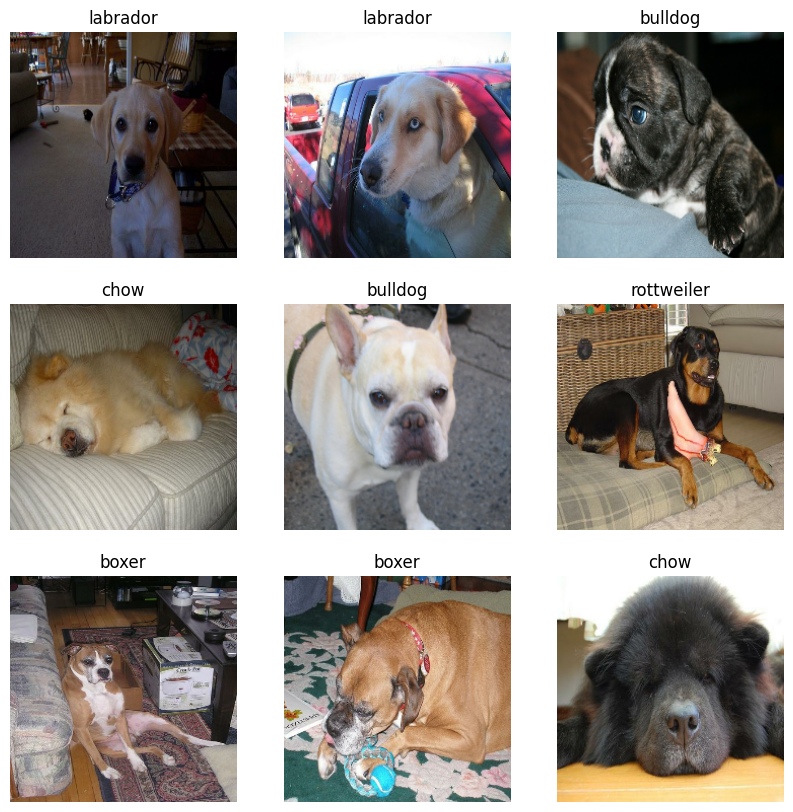

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [73]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_data))
print('Number of val batches: %d' % tf.data.experimental.cardinality(val_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of validation batches: 39
Number of val batches: 12
Number of test batches: 5


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [74]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [75]:
# Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

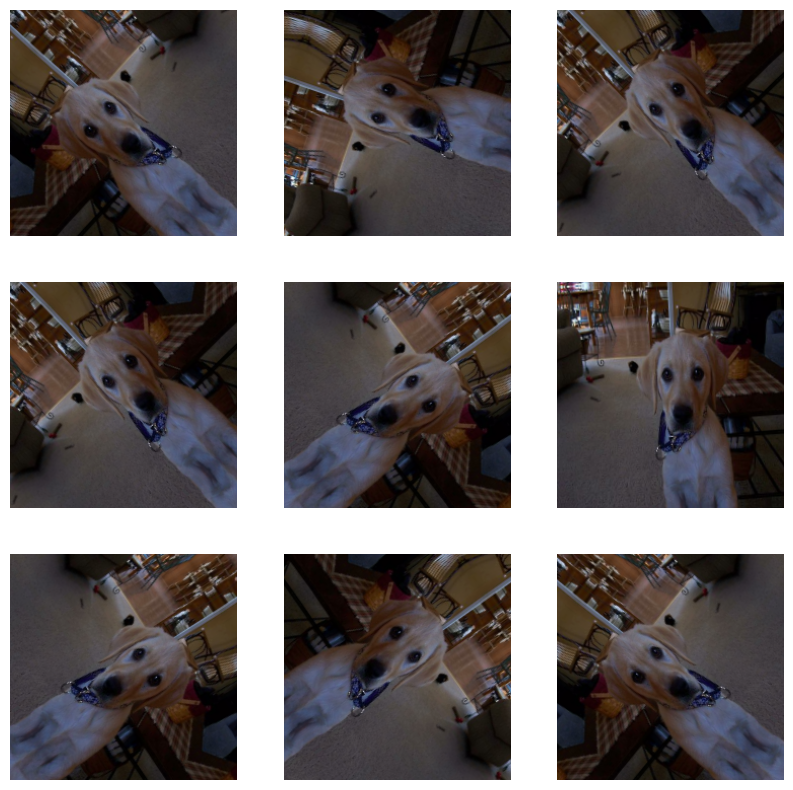

In [76]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [77]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [78]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [79]:
# Paramètres du modèle
img_height = x_train.shape[1]
img_width = x_train.shape[2]
IMG_SIZE = (img_height, img_width)

In [80]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `224x224x3` image into a `7x7x1280` block of features. Let's see what it does to an example batch of images:

In [81]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [82]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [83]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [84]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [85]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [86]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [87]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 11.5 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [88]:
len(model.trainable_variables)

2

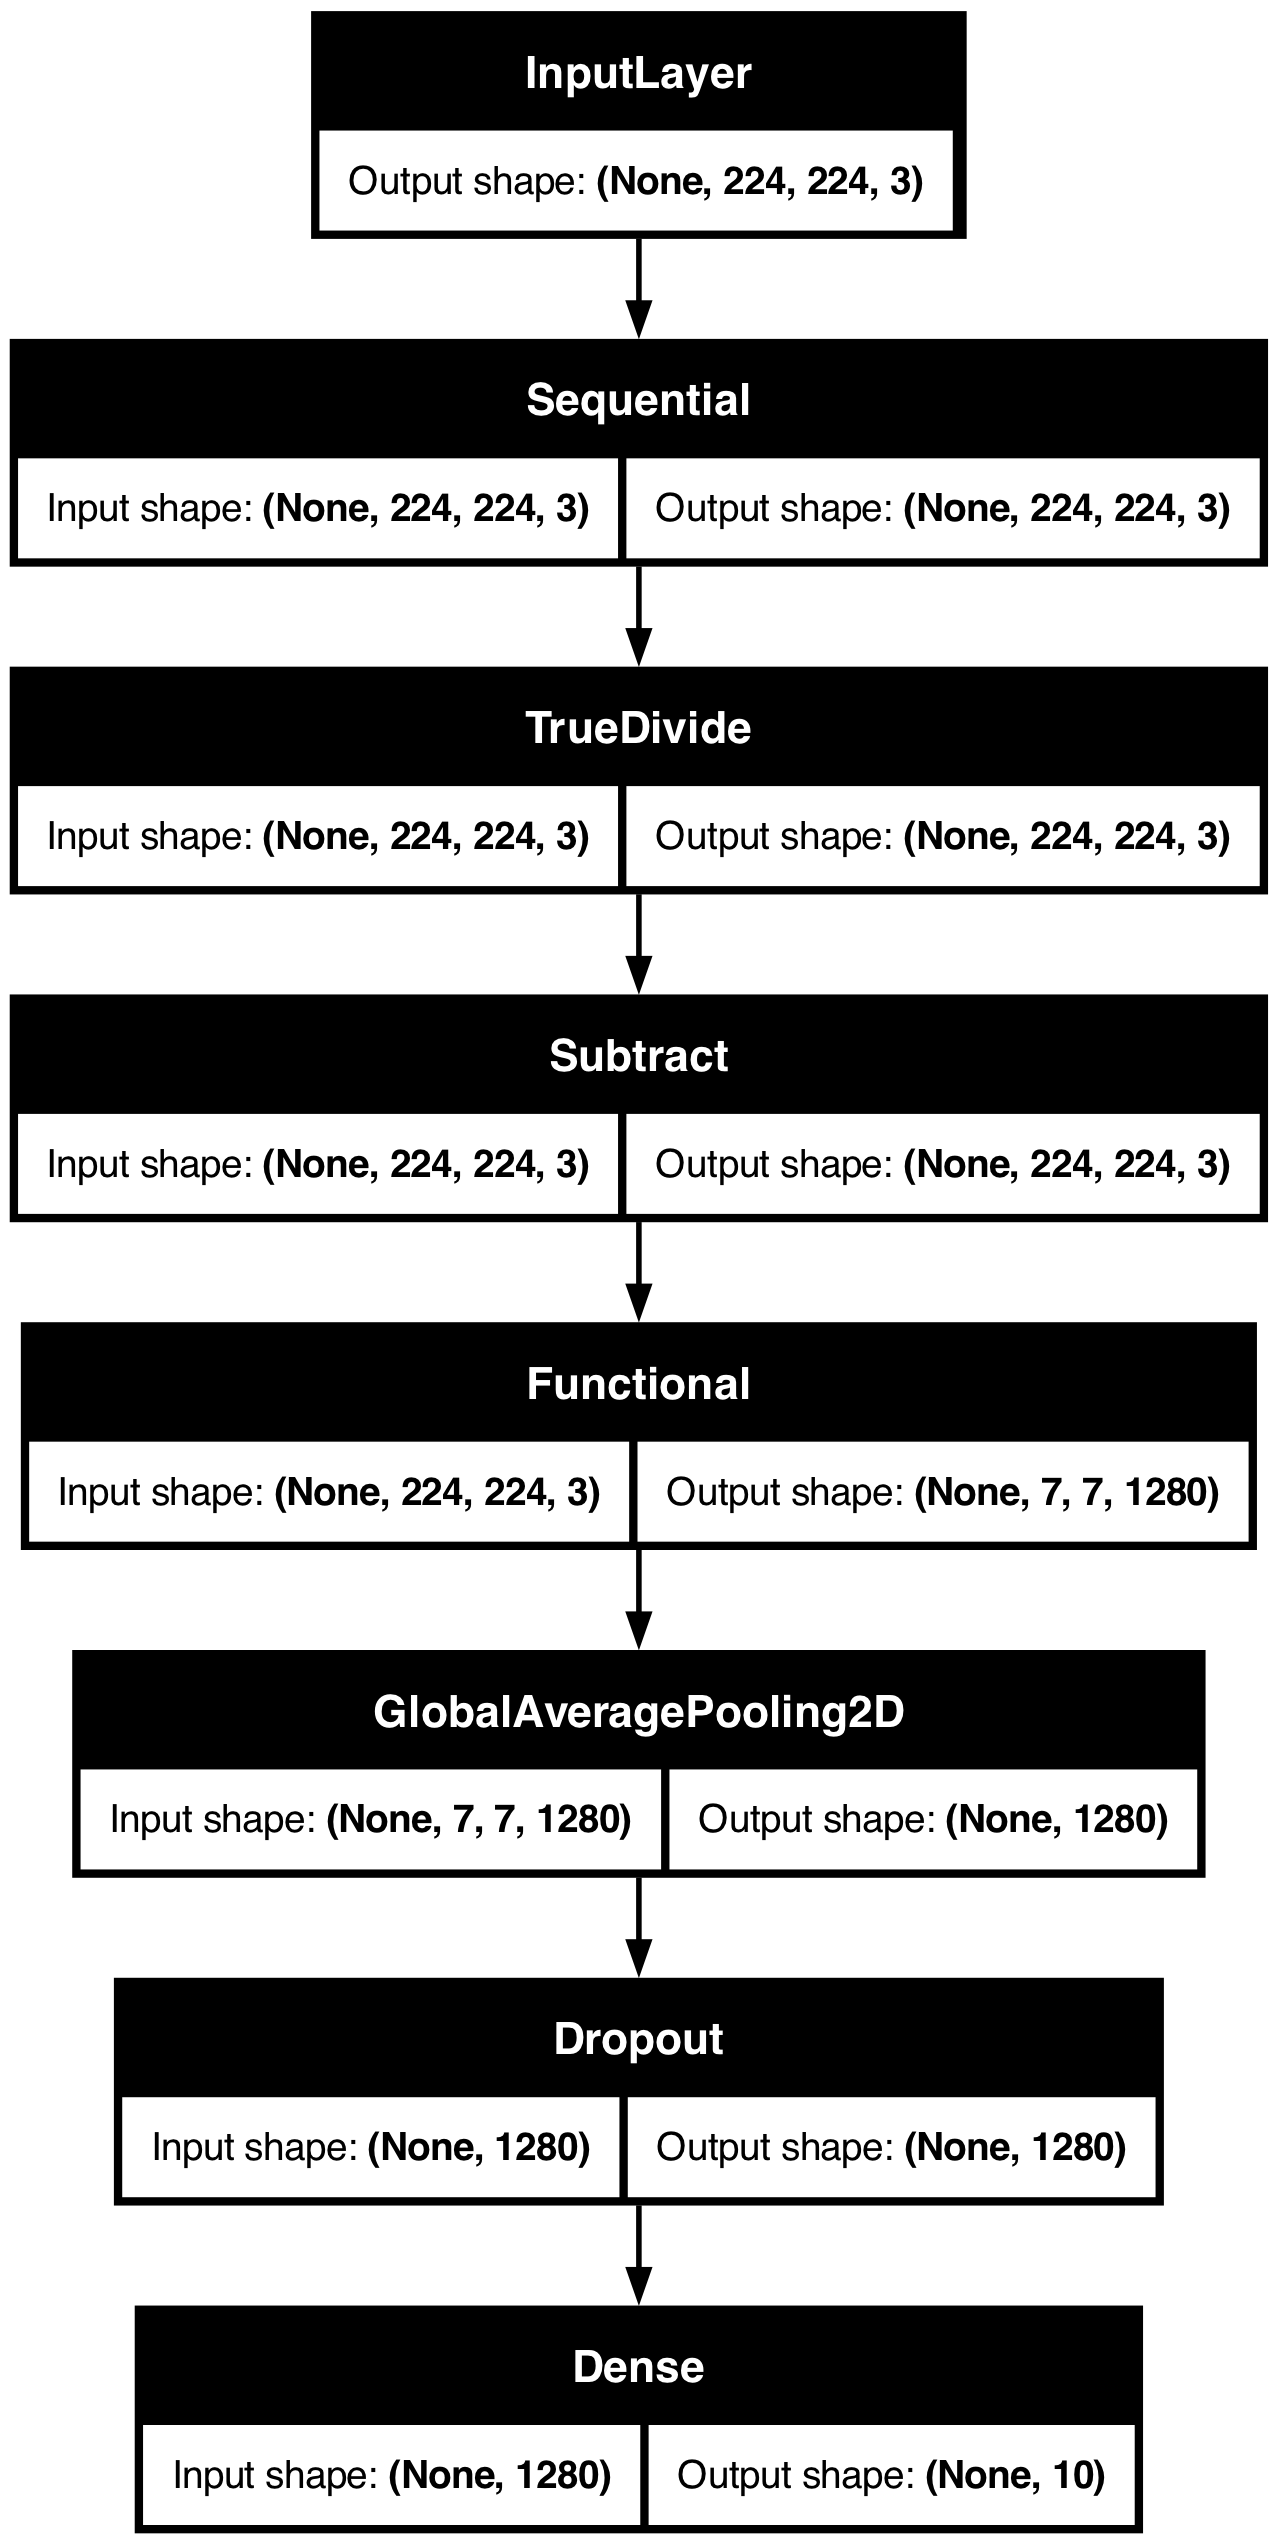

In [89]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it.

In [90]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

After training for 20 epochs, you should see ~84% accuracy on the validation set.


In [91]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - accuracy: 0.1789 - loss: 2.5028


In [92]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.45
initial accuracy: 0.18


In [93]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[tensorboard_callback, bestmodel_callback]
                    )

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.1720 - loss: 2.5174
Epoch 1: val_accuracy improved from -inf to 0.31461, saving model to ./run_transfer_mobilnetv2_v2/models/best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.1720 - loss: 2.5143 - val_accuracy: 0.3146 - val_loss: 1.9503
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2737 - loss: 2.0279
Epoch 2: val_accuracy improved from 0.31461 to 0.53652, saving model to ./run_transfer_mobilnetv2_v2/models/best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.2747 - loss: 2.0262 - val_accuracy: 0.5365 - val_loss: 1.5846
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4324 - loss: 1.7129
Epoch 3: val_accuracy improved from 0.53652 to 0.71629, saving model to ./run_transfer_mobilnetv2_v2/models/best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.4333 - loss: 1.7115 - val_accuracy: 0.7163 - val_loss: 1.3003
Epoch 4/20
39/39

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

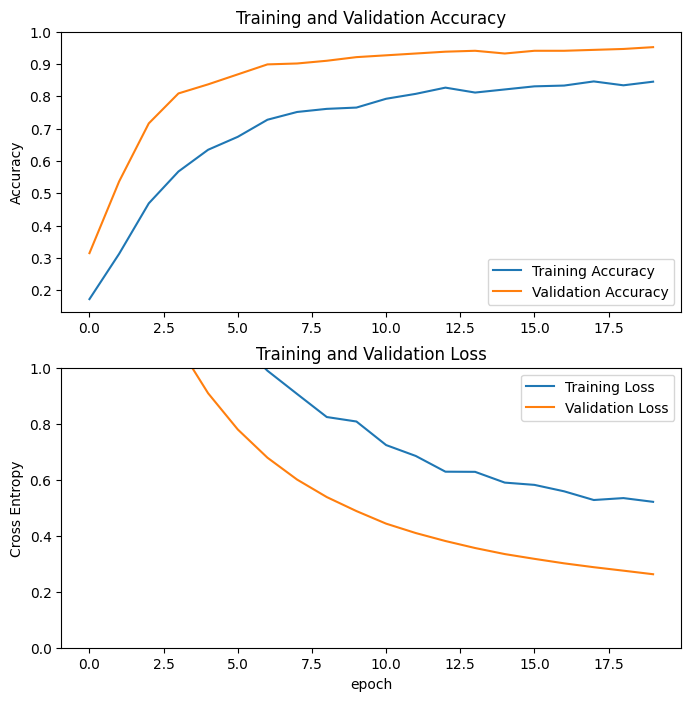

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [95]:
base_model.trainable = True

In [96]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [97]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [98]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,874,250 (7.15 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [99]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [100]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data,
                         callbacks=[tensorboard_callback, bestmodel_callback]
                         )

Epoch 20/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.6918 - loss: 0.9765
Epoch 20: val_accuracy did not improve from 0.95225
39/39 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6918 - loss: 0.9760 - val_accuracy: 0.9410 - val_loss: 0.2381
Epoch 21/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7441 - loss: 0.8049
Epoch 21: val_accuracy did not improve from 0.95225
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7439 - loss: 0.8052 - val_accuracy: 0.9382 - val_loss: 0.2215
Epoch 22/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.7804 - loss: 0.7252
Epoch 22: val_accuracy did not improve from 0.95225
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 917ms/step - accuracy: 0.7801 - loss: 0.7256 - val_accuracy: 0.9354 - val_loss: 0.2114
Epoch 23/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8000 - loss: 0.6740
Epoch 23: val_accuracy did not improve from 0.95225
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 806ms/step - accuracy: 0.7999 - loss: 0.6739 - val_accuracy: 0.9354 

In [101]:
# Sauvegarder le modèle final
model.save(f'{run_dir}/models/last_model.keras')

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 88% accuracy on the validation set.

In [102]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

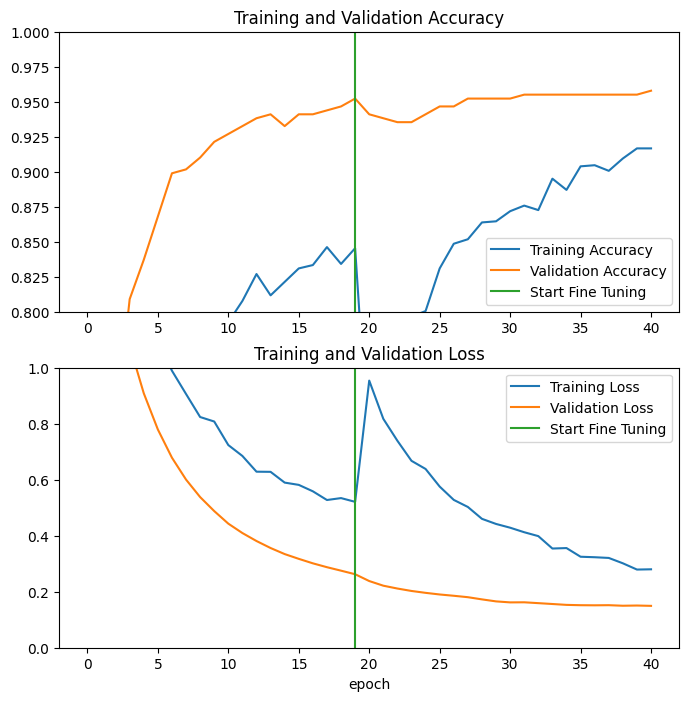

In [103]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [104]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9785 - loss: 0.1173
Test accuracy : 0.956250011920929


And now you are all set to use this model to predict if your pet is a cat or dog.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions:
 [8 6 1 2 1 5 4 6 1 6 7 6 5 6 2 6 8 0 0 0 1 5 9 5 3 3 1 9 6 0 4 4]
Labels:
 [8 6 1 2 1 5 4 6 1 6 7 6 5 6 2 6 8 0 0 0 1 5 9 5 3 3 1 9 6 0 4 4]


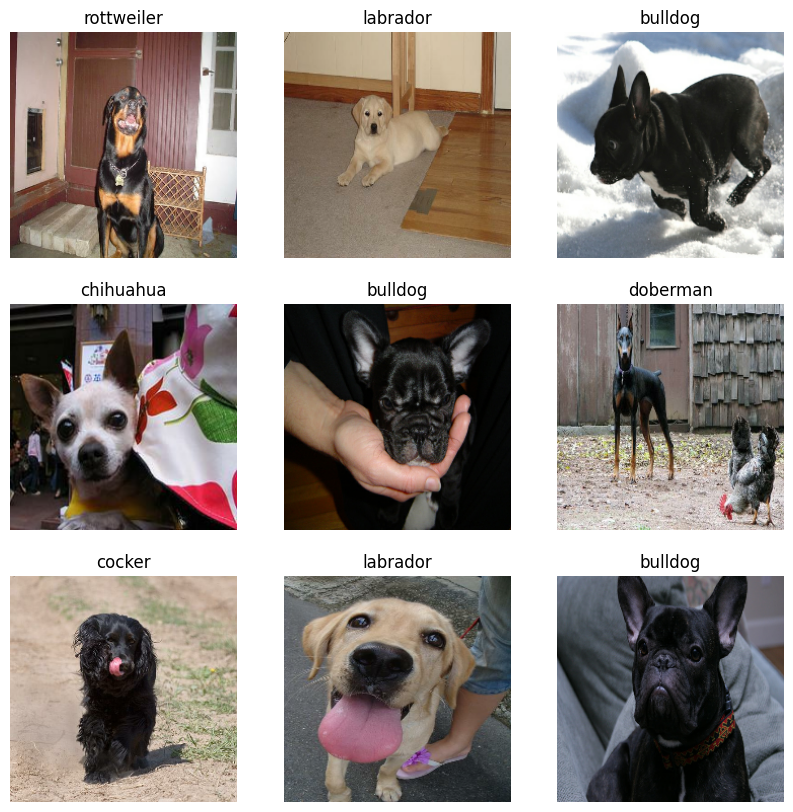

In [105]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict(image_batch)
predictions = np.argmax(predictions, axis=-1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


## Bonus: Confusion matrix and more predictions

### Confusion Matrix

In [106]:
import itertools
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [107]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    target_names = [class_names[label] for label in range(len(class_names))]

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    figname=f'{save_as}'
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(figs_dir+'/'+figname+'.png')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


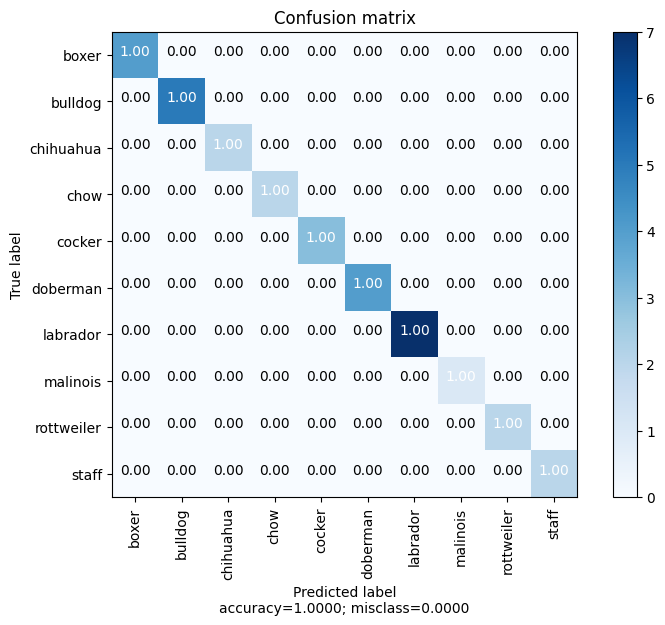

In [108]:
image_batch, y_test = test_data.as_numpy_iterator().next()
predictions = model.predict(image_batch)
y_pred = np.argmax(predictions, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

### Prediction using a meta dataset

In [111]:
directory_path = './dataset_meta_2'

# Create the meta dataset using image_dataset_from_directory
meta_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    batch_size=num_classes,
    image_size=IMG_SIZE,
    shuffle=False,  # No need to shuffle, as one image per class
)

# Print class names
meta_class_names = meta_dataset.class_names
print("Meta class names:", meta_class_names)

x_meta = []
y_meta = []
for images, labels in meta_dataset:
    x_meta.append(images.numpy().astype("uint8"))
    y_meta.append(labels)

# Concatenate into tensors and convert to numpy arrays
x_meta = tf.concat(x_meta, axis=0).numpy()
y_meta = tf.concat(y_meta, axis=0).numpy()

Found 10 files belonging to 10 classes.
Meta class names: ['boxer', 'bulldog', 'chihuahua', 'chow', 'cocker', 'doberman', 'labrador', 'malinois', 'rottweiler', 'staff']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step

Output layer from model is (x100) :

[[ 0.01  0.04  0.07  0.04 99.11  0.01  0.64  0.    0.07  0.01]]

Graphically :



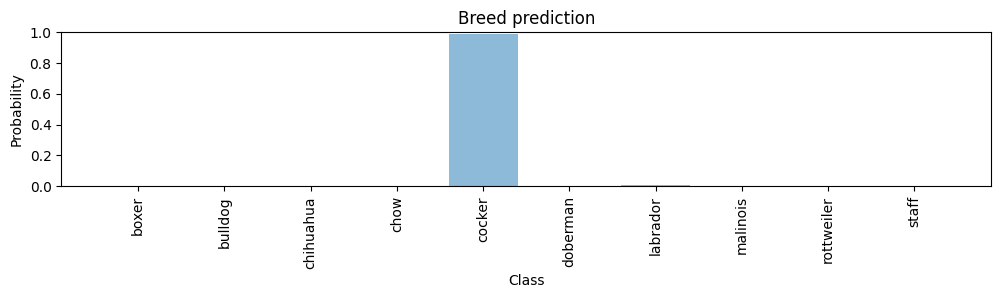


The image :                         Prediction :                      Real stuff:


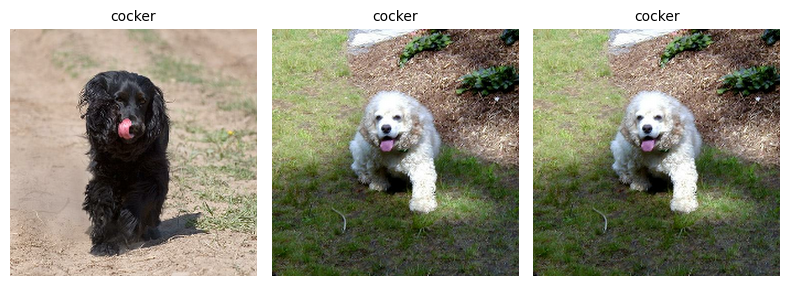

YEEES ! that's right!


In [112]:
import random

# ---- Get a random image
#
x_test, y_test = test_data.as_numpy_iterator().next()
i    = random.randint(1,len(x_test)-1)
x, y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = model.predict(np.array([x]))

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(num_classes), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))

target_names = [class_names[label] for label in range(len(class_names))]
tick_marks = np.arange(len(target_names))

plt.xticks(tick_marks, target_names, rotation=90)
plt.xlabel('Class')
plt.title('Breed prediction')
plt.savefig(figs_dir+'/prediction-proba.png', bbox_inches='tight')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :                         Prediction :                      Real stuff:")

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, 3, figsize=(8, 6))
# fig.subplots_adjust(hspace=.5)
x_list = [x.astype("uint8"), x_meta[p], x_meta[y]]
y_list_strings = [class_names[label] for label in [y, p, y]]
# Generate and plot the images in a loop
for i in range(3):
    image = x_list[i]
    name = y_list_strings[i]
    
    # Get the current axis and plot the image
    ax = axes[i%3]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name, fontsize=10)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.savefig(figs_dir+'/prediction-images.png')
plt.show()

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong :(")